# Subset 2003 Analysis with Xarray
This Notebook provides an overview, as well as practical examples, to access and analyse a subset of NetCDF data from available campaigns collected in the year 2003. This subset of data has been prepared and uploaded on the Hyrax server (https://opendap.terradue.com/hyrax/data/subset_2003/), where it can be accessed directly.

In [2]:
# Import modules
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pprint
import xarray as xr
import requests
import re

## Helper Functions

In [3]:
# Function to retrieve DDS info (sizes of 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION')
def retrieveDDSinfo(dds):
    
    # Function to extract the dimension of a specific keyword
    def findDim(txt, key):
        sel = [elem for elem in txt if key in elem]
        assert len(sel)==1

        dim = int(sel[0].split(' = ')[-1].strip(']'))-1
        return dim    
    
    r = requests.get(dds)
    
    unique_list = set(re.findall(r'\[.*?\]',r.text))
#     print('Unique elements:', unique_list)
    
    keys = ['TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION']

    dim_dict = {}

    for k in keys:
        dim_dict[k] = findDim(txt=unique_list, key=k)

    return dim_dict

In [4]:
# Function to build a string for query on URL
def getQueryString(mydict, keylist):
#     print('Retriving Query string for keywords:', keylist)
    
    que_str = ','.join([f'{key}[0:1:{mydict[key]}]' for key in mydict.keys() if key in keylist])
#     print('Query string:', que_str)
    return que_str

In [5]:
# Function to filter XARRAY based on platform, Var and DEPTH
def filter_xarr(df_toPlot, data_dict, platform, var, depth_range):
    
    # find indices for each platform for the selected data
    index = df_toPlot[df_toPlot['Platform']==platform].index.tolist()
    
    print(f'DEPTH range: {depth_range[0]} - {depth_range[1]}')
    
    # Filer data using the indexes of the filtered elements
    xarr_sel = data_dict[platform]['data'].isel(TIME=index,
                                                DEPTH=slice(depth_range[0], depth_range[1]))[var]
    
    return xarr_sel

In [6]:
# Function to adjust data array with Vertical Min
def adjust_with_vmin(xarr_var, value):
    
    xarr_var = np.insert(xarr_var, obj=0, values=value, axis=1)
    #print('Adjusted shape:', xarr_var.shape)
    #display(xarr_var)

    # Remove last element (ie same dimension as original)
    xarr_var_trimmed = xarr_var[:,:-1]
    #print('Trimmed shape:', xarr_var_trimmed.shape)
    #display(xarr_var_trimmed)
    
    # return the trimmed array, to re-assign it to the original element
    return xarr_var_trimmed

In [7]:
# Function to plot a specific variable
def plotFilteredVar(data_xarr_var, title):
    plt.figure()
    # display(data_xarr)
    data_xarr_var.plot()
    plt.title(title)

In [8]:
# Function to plot a specific variable across the merged platforms
def plotVar_MergedPlatforms(merged_arr_var, var, title):
    plt.figure()
    merged_arr_var[var].plot() 
    plt.title(title)

In [9]:
# Function to create a new xarray. DataArray
def newXDA(oldarr, newarr_data, var):
    da = xr.DataArray(
        data=newarr_data, # this is the actual numpy array with the new desired shape
        dims=oldarr.dims, # copy dimensions names from the old array (eg TIME, DEPTH)
        coords=oldarr.coords, # copy coords
        attrs=oldarr.attrs, # copy attrs
        name=var # define var name
    )
    
    return da

## Set-up

### Server URL

In [10]:
# Define URLs of servers  
hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/' # on HYRAX server
thredds_url = 'https://opendap.terradue.com/thredds/dodsC/subset_2003/' # on THREDDS server

# Choose the one you want to use (hyrax_url or thredds_url)
server_url = hyrax_url # or thredds_url

### Define Year and Platform Codes 
The information on **year** and **platforms** available on the server (the individual NetCDF files) must be known a priori 

In [11]:
year = 2003 # Define year of interest
platform_codes = ['AA', 'GS', 'GT', 'HJ', 'JH'] # Define codes of platforms of interest

## Retrieval of DDS info
Access data using the dds info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION'

In [12]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

for pc in platform_codes:
    
    dds = f'{server_url}/58{pc}_CTD_{year}.nc.nc4.dds'
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

#pprint.pprint(pc_dim_dict)
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


## Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

### Create Position_Dict

In [13]:
position_dict = {}

for pc in platform_codes:
    
    que_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc.nc4?{que_str}'; print(f'Platform: {pc}. URL with Queries:', url)

    remote_data = xr.open_dataset(
        url,
        decode_times=False,
    )   
    
    lon_min = float(remote_data.attrs['geospatial_lon_min'])
    lon_max = float(remote_data.attrs['geospatial_lon_max'])
    lat_min = float(remote_data.attrs['geospatial_lat_min'])
    lat_max = float(remote_data.attrs['geospatial_lat_max'])

    plat_code = remote_data.attrs['platform_code']
    plat_name = remote_data.attrs['platform_name']
    dtype = remote_data.attrs['data_type']
    title = remote_data.attrs['title']
    inst = remote_data.attrs['instrument']
    v_min = remote_data.attrs['geospatial_vertical_min']
    v_max = remote_data.attrs['geospatial_vertical_max']

    data_attr = np.array([plat_code, plat_name, year, dtype, title, inst, 
                         v_min, v_max, lon_min, lon_max, lat_min, lat_max])   
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GT_CTD_2003.nc.nc4?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58HJ_CTD_2003.nc.nc4?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58JH_CTD_2003.nc.nc4?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms. 

In [14]:
# Load locations (long & lat) and TIME of ALL measurements
from datetime import datetime, timedelta
start_date = datetime(1950, 1, 1)
    
position_df = pd.DataFrame() # or gpd.GeoDataFrame()

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df = position_df.append(test) # or gpd.GeoDataFrame()
    
position_df['Index_ABS'] = np.arange(0,len(position_df))
position_df = position_df.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df)} measurement locations')
position_df

Platform AA: 684 measurement locations.


,Longitude,Latitude,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude,Latitude,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude,Latitude,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude,Latitude,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude,Latitude,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


In [15]:
# Save dataframe to csv
position_df.to_csv('all_locations.csv', sep=',', header=True)

### Plot all Positions
Plot locations on an interactive plot. 

First, define the dataframe that you would like to plot to the **df_toPlot** variable.

In [16]:
df_toPlot = position_df

Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [17]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook() # necessary to show the plot 

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Platform", "@Platform"),            
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
           title="Mouse over the dots")

# p.square('Longitude', 'Latitude', size=6, color='grey', fill_color='white', source=df_toPlot, legend_label="All locations")
p.circle('Longitude', 'Latitude', size=4, color='red', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='AA'], legend_label="Platform AA locations")
p.circle('Longitude', 'Latitude', size=4, color='blue', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GS'], legend_label="Platform GS locations")
p.circle('Longitude', 'Latitude', size=4, color='green', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GT'], legend_label="Platform GT locations")
p.circle('Longitude', 'Latitude', size=4, color='black', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='HJ'], legend_label="Platform HJ locations")
p.circle('Longitude', 'Latitude', size=4, color='orange', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='JH'], legend_label="Platform JH locations")

# Add area
# p.quad(left=bbox[0], right=bbox[1], top=bbox[3], bottom=bbox[2], legend_label="Bounding Box", fill_color='grey', fill_alpha=0.0, line_color="black")

p.legend.location = "bottom_right"
show(p)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

### Filter Positions (based on *position_df*)
This section shows a few examples of filtering our data. The following filters are included:
* filter by bounding box (BBOX)
* filter by BBOX and platform's month of collection 
* filter by BBOX and platform's time (hour) of collection

#### Filter by BBOX

In [18]:
# Now apply the arctic bounding box in the format: minLong - maxLong; minLat - maxLat (eg 30W - 60E; 50N - 80 N) 
bbox_dict = {}

bbox_dict['BBOX=ALL'] = [-20, 70, 40, 90] 
bbox_dict['BBOX=Arctic'] = [-30, 60, 50, 80]  
bbox_dict['BBOX=North Sea'] = [-5, 15, 50, 60]

bbox_key = 'BBOX=North Sea'; assert bbox_key in bbox_dict.keys(), 'Key error, please check.'
bbox = bbox_dict[bbox_key]

In [19]:
len(position_df)

3209

In [20]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox[3])]
print('Year:', year)
print('BBOX:', bbox_key)

sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox)
#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

Year: 2003
BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


#### Filter by BBOX and Month

In [21]:
month = '08'
period = f'{year}-{month}'
condition = (position_df_bbox['Time']).astype(str).str.contains(period)
position_df_bbox_mm = position_df_bbox[condition]

sel_outof_all = f'{len(position_df_bbox_mm)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

position_df_bbox_mm

Selected positions (out of available positions): 0 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,


#### Filter by BBOX and Hour

In [22]:
hour = '05'
hour_expr = f' {hour}:'
condition = (position_df_bbox['Time']).astype(str).str.contains(hour_expr)
position_df_bbox_hh = position_df_bbox[condition]

sel_outof_all = f'{len(position_df_bbox_hh)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

position_df_bbox_hh

Selected positions (out of available positions): 24 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
55,8.1632,57.915798,2003-01-19 05:22:18,AA,55
70,6.3377,57.000198,2003-01-20 05:29:17,AA,70
80,4.6975,57.000702,2003-01-22 05:56:00,AA,80
99,-0.2325,56.999298,2003-01-24 05:14:13,AA,99
141,2.9035,59.282700,2003-03-07 05:06:37,AA,141
142,2.7532,59.282700,2003-03-07 05:45:36,AA,142
159,-2.0922,58.949699,2003-03-08 05:23:26,AA,159
170,3.3368,58.001202,2003-03-09 05:42:38,AA,170
220,7.2558,55.664200,2003-03-15 05:17:13,AA,220


## Processing: Load and Plot all needed Data (Variables and their Attributes)

All data (variables and their attributes) for each platform are read iteratively, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

### Create **data_dict** dictionary 

In [23]:
data_dict = {}

for pc in platform_codes:
    
    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

    url = server_url + fix_lab + '.nc.nc4'; print(url)
    
    remote_data = xr.open_dataset(
        url,
        decode_times=False,
    )   
    
    lon_min = float(remote_data.attrs['geospatial_lon_min'])
    lon_max = float(remote_data.attrs['geospatial_lon_max'])
    lat_min = float(remote_data.attrs['geospatial_lat_min'])
    lat_max = float(remote_data.attrs['geospatial_lat_max'])

    plat_code = remote_data.attrs['platform_code']
    plat_name = remote_data.attrs['platform_name']
    dtype = remote_data.attrs['data_type']
    title = remote_data.attrs['title']
    inst = remote_data.attrs['instrument']
    v_min = remote_data.attrs['geospatial_vertical_min']
    v_max = remote_data.attrs['geospatial_vertical_max']

    data_attr = np.array([plat_code, plat_name, year, dtype, title, inst, 
                         v_min, v_max, lon_min, lon_max, lat_min, lat_max])   
    
    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}
    
    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4
['58AA' 'H\\\\303\\\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4
['58GS' 'G.O. Sars' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '1.000'
 '3688.000' '-17.979' '22.532' '59.28' '78.336']

https://opendap.terradue.com/hyrax/data/subset_2003/58GT_CTD_2003.nc.nc4
['58GT' 'Sarsen' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '1.000'
 '2962.000' '-9.52' '35.016' '56.667' '78.655']

https://opendap.terradue.com/hyrax/data/subset_2003/58HJ_CTD_2003.nc.nc4
['58HJ' 'Helmer Hanssen' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '1.000'
 '792.000' '6.303' '39.826' '

### Create Overview Dataframe with Platforms' Attributes
This provides detailed information about each campaign at sea. An overview dataframe (*overview_df*) is created to store the campaigns' main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)

In [24]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()

for key in data_dict.keys():
    
    overview_df.loc[key,'Platform_code'] = [data_dict[key]['data_attr'][0].astype(str)]
    overview_df.loc[key,'Platform_name'] = [data_dict[key]['data_attr'][1].astype(str)]
    overview_df.loc[key,'Year'] = [data_dict[key]['data_attr'][2].astype(int)]
    overview_df.loc[key,'Data_type'] = [data_dict[key]['data_attr'][3].astype(str)]
    overview_df.loc[key,'Title'] = [data_dict[key]['data_attr'][4].astype(str)]
    overview_df.loc[key,'Instrument'] = [data_dict[key]['data_attr'][5].astype(str)]
    overview_df.loc[key,'Vertical_min'] = [data_dict[key]['data_attr'][6].astype(float)]
    overview_df.loc[key,'Vertical_max'] = [data_dict[key]['data_attr'][7].astype(float)]
    overview_df.loc[key,'Lon_min'] = [data_dict[key]['data_attr'][8].astype(float)]
    overview_df.loc[key,'Lon_max'] = [data_dict[key]['data_attr'][9].astype(float)]
    overview_df.loc[key,'Lat_min'] = [data_dict[key]['data_attr'][10].astype(float)]
    overview_df.loc[key,'Lat_max'] = [data_dict[key]['data_attr'][11].astype(float)]
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\\303\\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
HJ,58HJ,Helmer Hanssen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,792.0,6.303,39.826,63.889,81.179
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [31]:
# Extract / define the variables to use for the analysis
for key in data_dict.keys():
    print(key, list(data_dict[key]['data'].variables))

# Select the variables of interest, of those existing
common_vars = ['PRES', 'TEMP', 'PSAL', 'CNDC']
assert all(elem in data_dict[key]['data'].variables for elem in common_vars for key in data_dict.keys())

AA ['TIME', 'TIME_QC', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'DIRECTION', 'PRES', 'PRES_QC', 'PRES_DM', 'TEMP', 'PSAL', 'CNDC', 'TEMP_QC', 'PSAL_QC', 'CNDC_QC', 'TEMP_DM', 'PSAL_DM', 'CNDC_DM']
GS ['TIME', 'TIME_QC', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'DIRECTION', 'PRES', 'PRES_QC', 'TEMP', 'PSAL', 'CNDC', 'TEMP_QC', 'PSAL_QC', 'CNDC_QC']
GT ['TIME', 'TIME_QC', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'DIRECTION', 'PRES', 'PRES_QC', 'TEMP', 'PSAL', 'CNDC', 'TEMP_QC', 'PSAL_QC', 'CNDC_QC']
HJ ['TIME', 'TIME_QC', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'DIRECTION', 'PRES', 'PRES_QC', 'TEMP', 'PSAL', 'CNDC', 'TEMP_QC', 'PSAL_QC', 'CNDC_QC']
JH ['TIME', 'TIME_QC', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'DIRECTION', 'PRES', 'PRES_QC', 'TEMP', 'PSAL', 'CNDC', 'TEMP_QC', 'PSAL_QC', 'CNDC_QC']


In [89]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in common_vars:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'PRES': False, 'TEMP': False, 'PSAL': False, 'CNDC': False},
 'GT': {'PRES': False, 'TEMP': False, 'PSAL': False, 'CNDC': False},
 'HJ': {'PRES': False, 'TEMP': False, 'PSAL': False, 'CNDC': False},
 'JH': {'PRES': False, 'TEMP': False, 'PSAL': False, 'CNDC': False}}

### Filtered data (*position_df* & *data_dict*)
This section allows selecting one or more variables for each platform, and DEPTH range, to the BBOX-filtered data. The available variables in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity

First, define the filtered dataframe to use for the analysis (eg *position_df_bbox*, *position_df_bbox_mm*, *position_df_bbox_hh*) to the **df_toPlot** variable.

In [109]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox
print('BBOX:', bbox_key)

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(df_toPlot)

BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


#### Filtered data by BBOX and One Variable

In [37]:
# Defing platform and var to plot
pc = 'AA' # platform code
var = 'TEMP' # variable

In [40]:
# Generate a filtered xarray with a single variable for selected Platform

xarr = data_dict[pc]['data']
xarr_var = xarr[var].data

vmin = float(xarr.attrs['geospatial_vertical_min'])

if vmin == 0:
    print(f'Platform: {pc} - Vertical min = {vmin}')
elif vmin == 1 and vmin_dict[pc][var]==False: 
    print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
    data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
    vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

print(f'Dimensions: TIME={xarr_var.shape[0]}, DEPTH={xarr_var.shape[1]}') 

filtered_xarr = filter_xarr(df_toPlot, data_dict, platform=pc, var=var, depth_range=[0,depth_stop_dict[pc]])
filtered_xarr

Platform: AA - Vertical min = 0.0
Dimensions: TIME=684, DEPTH=2810
DEPTH range: 0 - 2809


<xarray.DataArray 'TEMP' (TIME: 357, DEPTH: 2809)>
array([[8.094, 8.089, 8.088, ...,   nan,   nan,   nan],
       [7.567, 7.568, 7.568, ...,   nan,   nan,   nan],
       [7.359, 7.353, 7.354, ...,   nan,   nan,   nan],
       ...,
       [8.67 , 8.575, 8.906, ...,   nan,   nan,   nan],
       [9.227, 9.277, 9.353, ...,   nan,   nan,   nan],
       [9.507, 9.506, 9.51 , ...,   nan,   nan,   nan]])
Coordinates:
  * TIME     (TIME) float64 1.937e+04 1.937e+04 ... 1.968e+04 1.968e+04
Dimensions without coordinates: DEPTH
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

#### Filtered data by BBOX (All Variables)

In [ ]:
# Defing platform to plot
pc = 'GT' # platform code
# data_dict['AA']['data'][['TEMP','PSAL']] # to select multiple variables

In [ ]:
# Generate a filtered xarray with all variables for selected Platform

for var in common_vars: 

    xarr = data_dict[pc]['data']
    xarr_var = xarr[var].data

    vmin = float(xarr.attrs['geospatial_vertical_min'])

    if vmin == 0:
        print(f'Platform: {pc} - Vertical min = {vmin}')
    elif vmin == 1 and vmin_dict[pc][var]==False: 
        print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
        data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
        vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

    
    #print(f'Dimensions: TIME={xarr_var.shape[0]}, DEPTH={xarr_var.shape[1]}') 

filtered_xarr = filter_xarr(df_toPlot, data_dict, platform=pc, var=common_vars, depth_range=[0,depth_stop_dict[pc]])
filtered_xarr

#### Filtered data by BBOX and One Variable, within a DEPTH range

In [ ]:
# Defing platform and var to plot
pc = 'GT' # platform code
var = 'PSAL' # variable

depth_start = 5
depth_stop = 10

In [ ]:
# Generate a filtered xarray with one single VAR for selected Platform, for a certain DEPTH range

xarr = data_dict[pc]['data']
xarr_var = xarr[var].data

vmin = float(xarr.attrs['geospatial_vertical_min'])

if vmin == 0:
    print(f'Platform: {pc} - Vertical min = {vmin}')
elif vmin == 1 and vmin_dict[pc][var]==False: 
    print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
    data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
    vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

filtered_xarr = filter_xarr(df_toPlot, data_dict, platform=pc, var=var, depth_range=[depth_start,depth_stop])
filtered_xarr

#### Filtered data by BBOX (All Variables), within a DEPTH range

In [58]:
# Defing platform and var to plot
pc = 'GT' # platform code

depth_start = 5
depth_stop = 10

In [59]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range

for var in common_vars: 

    xarr = data_dict[pc]['data']
    xarr_var = xarr[var].data

    vmin = float(xarr.attrs['geospatial_vertical_min'])

    if vmin == 0:
        print(f'Platform: {pc} - Vertical min = {vmin}')
    elif vmin == 1 and vmin_dict[pc][var]==False: 
        print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
        data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
        vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

    #print(f'Dimensions: TIME={xarr_var.shape[0]}, DEPTH={xarr_var.shape[1]}') 

filtered_xarr = filter_xarr(df_toPlot, data_dict, platform=pc, var=common_vars, depth_range=[depth_start,depth_stop])
filtered_xarr

Platform: GT - Vertical min = 1.0 --> adjusting
Platform: GT - Vertical min = 1.0 --> adjusting
Platform: GT - Vertical min = 1.0 --> adjusting
Platform: GT - Vertical min = 1.0 --> adjusting
DEPTH range: 5 - 10


<xarray.Dataset>
Dimensions:  (DEPTH: 5, TIME: 158)
Coordinates:
  * TIME     (TIME) float64 1.954e+04 1.954e+04 ... 1.963e+04 1.964e+04
Dimensions without coordinates: DEPTH
Data variables:
    PRES     (TIME, DEPTH) float32 6.0 7.0 8.0 9.0 10.0 ... 8.0 9.0 10.0 11.0
    TEMP     (TIME, DEPTH) float64 17.48 17.2 16.82 16.6 ... 12.89 12.89 12.9
    PSAL     (TIME, DEPTH) float64 28.57 28.68 28.85 28.99 ... 35.2 35.2 35.2
    CNDC     (TIME, DEPTH) float64 37.82 37.73 37.6 37.59 ... 41.07 41.07 41.08
Attributes: (12/51)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    last_latitude_observation:      57.690
    geospatial_lon_min:             -9.520
    geospatial_lon_max:             35.016
    last_longitude_observation:     -0.515
    geospatial_vertical_min:        1.000
    geospatial_vertical_max:        2962.000

### Reference Plots
The plots are generated for the available **variables** of the **filtered** xarrays. On the y-axis is shown the TIME of the measurement (in *float* format, which needs to be converted to *datetime* format), and on the x-axis is the DEPTH of the measurement.

#### Plotting individual Variables per individual Platform

There are multiple VARs available from the applied filtered: ['PRES', 'TEMP', 'PSAL', 'CNDC']


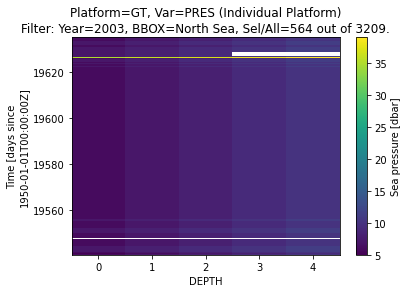

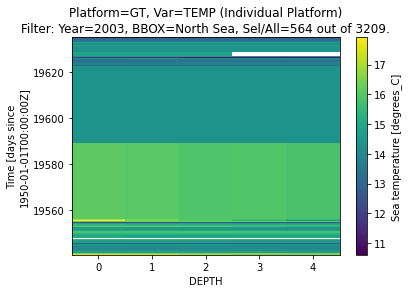

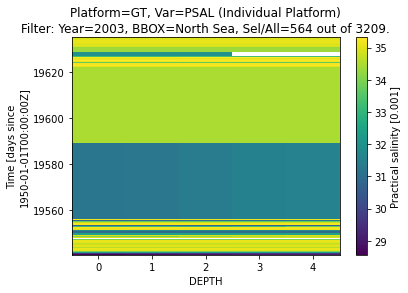

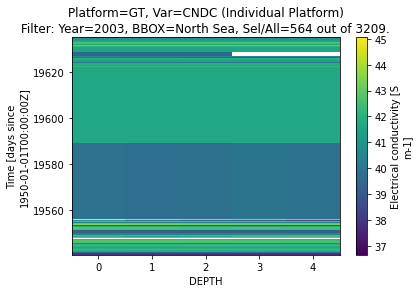

In [110]:
try:
    var = filtered_xarr.name
    print(f"There's only one VAR available from the applied filtered: {var}")
    
    title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}'
    
    plotFilteredVar(filtered_xarr, title=title)
    
except:
    myvars = list(filtered_xarr.keys())
    print(f"There are multiple VARs available from the applied filtered: {myvars}")
    
    for var in myvars:
        
        title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Sel/All={sel_outof_all}'

        plotFilteredVar(filtered_xarr[var], title=title)

#### Plotting individual Variables across aggregated Platforms
Build a dictionary that stores, for each platform and variable combination, the data sliced using the same DEPTH dimension in such a way to generate datasets that can be combined / merged.

##### Generate **filtered_xarr** for all Platforms

In [115]:
# Defing DEPTH range
depth_start = 5
depth_stop = 3000

In [116]:
PERCHE MOSTRA SOLO PLATFORM AA?!?!?
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
filtered_xarr_dict = {}

for pc in df_toPlot['Platform'].unique():
    
    for var in common_vars: 

        xarr = data_dict[pc]['data']
        xarr_var = xarr[var].data

        vmin = float(xarr.attrs['geospatial_vertical_min'])

        if vmin == 0:
            print(f'Platform: {pc} - Vertical min = {vmin}')
        elif vmin == 1 and vmin_dict[pc][var]==False: 
            print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
            data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
            vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

        #print(f'Dimensions: TIME={xarr_var.shape[0]}, DEPTH={xarr_var.shape[1]}') 

    filtered_xarr_dict[pc] = filter_xarr(df_toPlot, data_dict, platform=pc, var=common_vars, depth_range=[depth_start,depth_stop])
# filtered_xarr_dict

Platform: AA - Vertical min = 0.0
Platform: AA - Vertical min = 0.0
Platform: AA - Vertical min = 0.0
Platform: AA - Vertical min = 0.0
DEPTH range: 5 - 3000
DEPTH range: 5 - 3000
DEPTH range: 5 - 3000


In [91]:
data_var_dict = {}

for pc in df_toPlot['Platform'].unique(): 
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')

    for var in common_vars:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]

# display(data_var_dict)

PC AA	Filtered Dims: TIME=357, DEPTH=15
PC GS	Filtered Dims: TIME=49, DEPTH=15
PC GT	Filtered Dims: TIME=158, DEPTH=15


Definitions:
* min_depth = least common denominator for the DEPTH dimension found amongst the selected platforms
* max_depth = maximum value of the DEPTH dimension found amongst the selected platforms 


In [93]:
[print(data_var_dict[k]['TEMP'].shape) for k in data_var_dict.keys()]

# Find maximum and minimum DEPTH dimension among the platforms
max_depth = max([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('max_depth:', max_depth)
min_depth = min([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('min_depth:', min_depth)

(357, 15)
(49, 15)
(158, 15)
max_depth: 15
min_depth: 15


###### Aggregate with Min_depth
Use minimum DEPTH across the platforms' DEPTHs (ie reduce size)

In [94]:
# Use min_depth across available platforms: Reduce size to the minimum dimension 
print(f'Reshaping using minimum DAPTH dimension ({min_depth}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in ['TEMP', 'PRES', 'CNDC', 'PSAL']:
        
        data = data_var_dict[pc][var].isel(DEPTH=slice(0,min_depth)); #display(data_sel)
        
        print(f'{data_var_dict[pc][var].shape} --> {data.shape}')
        
        reshaped_dict[pc][var] = data
        
# reshaped_dict

Reshaping using minimum DAPTH dimension (15):
(357, 15) --> (357, 15)
(357, 15) --> (357, 15)
(357, 15) --> (357, 15)
(357, 15) --> (357, 15)
(49, 15) --> (49, 15)
(49, 15) --> (49, 15)
(49, 15) --> (49, 15)
(49, 15) --> (49, 15)
(158, 15) --> (158, 15)
(158, 15) --> (158, 15)
(158, 15) --> (158, 15)
(158, 15) --> (158, 15)


###### Aggregate with Max_depth
Use maximum DEPTH and fill empty values with nans (ie increase size)

Definition of the new xarray.DataArray
```# Create a new xarray.DataArray with same properties but larger DEPTH 
da = xr.DataArray(
    data=new_arr_data, # this is the actual numpy array with the new desired shape
    dims=old_arr.dims, # copy dimensions names from the old array (eg TIME, DEPTH)
    coords=old_arr.coords, # copy coords
    attrs=old_arr.attrs, # copy attrs
    name='PRES' # define var name
)
da
```

In [81]:
print(f'Reshaping using maximum DAPTH dimension ({max_depth}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in ['TEMP', 'PRES', 'CNDC', 'PSAL']:
        
        arr = data_var_dict[pc][var]
        
        # generate an empty array of nans, to then concatenate to the existing data array, to ensure it matches the desired new dimension DEPTH 
        fill = np.empty((arr.shape[0], max_depth-arr.shape[1]), dtype=arr.dtype); fill[:] = np.nan
        newarr_data = np.concatenate((arr.data,fill), axis=1)
        print(f'{arr.shape} --> {newarr_data.shape}')
        
        # Now create the xarray.DataArray
        newarr = newXDA(arr, newarr_data, var)
        
        reshaped_dict[pc][var] = newarr

# reshaped_dict

Reshaping using maximum DAPTH dimension (15):
(357, 15) --> (357, 15)
(357, 15) --> (357, 15)
(357, 15) --> (357, 15)
(357, 15) --> (357, 15)
(49, 15) --> (49, 15)
(49, 15) --> (49, 15)
(49, 15) --> (49, 15)
(49, 15) --> (49, 15)
(158, 15) --> (158, 15)
(158, 15) --> (158, 15)
(158, 15) --> (158, 15)
(158, 15) --> (158, 15)


##### Plotting Aggregate Results

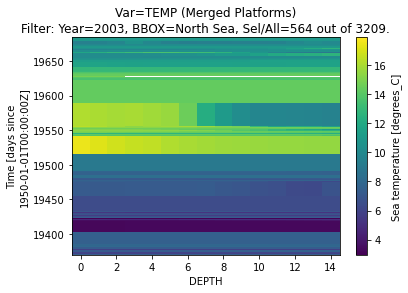

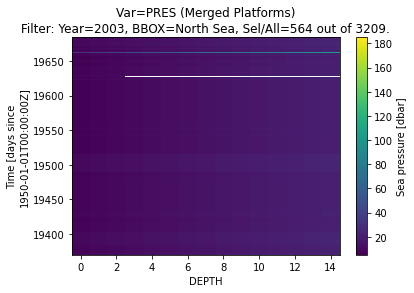

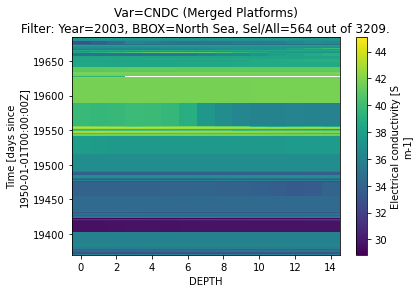

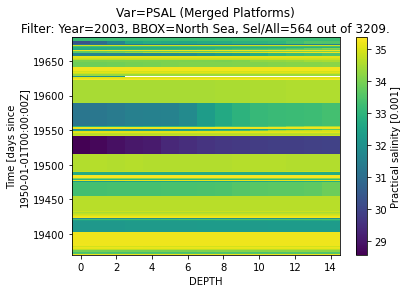

In [117]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in ['TEMP', 'PRES', 'CNDC', 'PSAL']:
    
    merged_arr[var] = xr.merge([reshaped_dict[pc][var] for pc in reshaped_dict.keys()])  
    
#     print(var, type(merged_arr[var]), merged_arr[var][var].shape) # Note you need double 'var' because the first is the key of teh dictionary, the second is the name of the var to plot
#     display(merged_arr[var])
    
    title = f'Var={var} (Merged Platforms)\nFilter: Year={year}, {bbox_key}, Sel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)